In [468]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm

from paolucci_functions import *

# Create dataframe

In [469]:
import os
import pandas as pd
import re
import numpy as np

def find_last_energy_value(filename):
    pattern = r"SCF Done:  E\(UPBE-PBE\) =  (-?\d+\.\d+)     A\.U\. after    \d+ cycles"
    last_energy = None
    
    with open(filename, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                last_energy = float(match.group(1))
    
    return last_energy

def parse_frequencies(file_path):
    pattern = r'Frequencies\s+--\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)'  # regex to find desired lines
    frequencies = []

    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                freq_values = match.groups()
                frequencies.extend(freq_values)
    
    # Convert strings to floats and cutoff frequencies below 100 cm^-1
    no_low_freq = [float(x) for x in frequencies if float(x) >= 100]
    
    return no_low_freq

def calculate_zpe(frequencies):
    h = 6.62607015e-34  # Planck's constant in J*s
    cm_to_hz = 2.99793e10  # convert cm^-1 to Hz
    Na = 6.022e23  # Avogadro's number 
    
    frequencies_array = np.array(frequencies, dtype=float)
    zpe = 0.5 * (h/1000) * np.sum(frequencies_array) * cm_to_hz * Na  # zero point energy in units of kJ/mol
    
    return zpe

def parse_ligand_file(file_name, file_dir):
    # Remove the file extension
    base_name = os.path.splitext(file_name)[0]
    
    # Initialize ligand counts
    n_nh3 = 0
    n_h2o = 0
    n_c2h4 = 0
    
    # Define regular expressions for ligands
    nh3_pattern = re.compile(r'(\d+)_nh3')
    h2o_pattern = re.compile(r'(\d+)_h2o')
    c2h4_pattern = re.compile(r'(\d+)_c2h4')
    
    # Find all matches
    nh3_match = nh3_pattern.search(base_name)
    h2o_match = h2o_pattern.search(base_name)
    c2h4_match = c2h4_pattern.search(base_name)
    
    if nh3_match:
        n_nh3 = int(nh3_match.group(1))
    if h2o_match:
        n_h2o = int(h2o_match.group(1))
    if c2h4_match:
        n_c2h4 = int(c2h4_match.group(1))
    
    # The remaining part after the ligand patterns is the description
    description_parts = nh3_pattern.sub('', base_name)
    description_parts = h2o_pattern.sub('', description_parts)
    description_parts = c2h4_pattern.sub('', description_parts)
    description = description_parts.strip('_')
    
    # Read the log file to find the total energy and frequencies
    total_energy = find_last_energy_value(os.path.join(file_dir, file_name))
    frequencies = parse_frequencies(os.path.join(file_dir, file_name))
    zpe = calculate_zpe(frequencies)
    
    return n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, os.path.join(file_dir, file_name)

def extract_data_from_directory(base_dir):
    data = []
    
    for metal_dir in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, metal_dir)):
            # Extract metal and charge information
            metal = ''.join([i for i in metal_dir if not i.isdigit()])
            charge = ''.join([i for i in metal_dir if i.isdigit()])
            
            for geometry_dir in os.listdir(os.path.join(base_dir, metal_dir)):
                if os.path.isdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                    geometry = geometry_dir.replace('_', ' ').capitalize()
                    
                    for ligand_file in os.listdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                        if ligand_file.endswith('.log'):  # replace with your file extension
                            n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, file_path = parse_ligand_file(ligand_file, os.path.join(base_dir, metal_dir, geometry_dir))
                            
                            data.append({
                                'Metal': metal.capitalize(),
                                'Charge': charge,
                                'Geometry': geometry,
                                'NH3': n_nh3,
                                'H2O': n_h2o,
                                'C2H4': n_c2h4,
                                'Description': description,
                                'Total Energy (Hartree)': total_energy,
                                'ZPE (kJ/mol)': zpe,
                                'File Path': file_path
                            })
    
    return pd.DataFrame(data)

# Set the base directory path
base_directory = '/Users/mohan/Desktop/Research/paolucci/data/freq'

# Extract the data into a dataframe
df = extract_data_from_directory(base_directory)

# Display the dataframe
df


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path
0,Cu,2,Square planar,1,3,0,,-1925.257977,293.629551,/Users/mohan/Desktop/Research/paolucci/data/fr...
1,Cu,2,Square planar,0,4,0,,-1945.082482,258.343882,/Users/mohan/Desktop/Research/paolucci/data/fr...
2,Cu,2,Square planar,2,2,0,90apart,-1905.432240,327.923744,/Users/mohan/Desktop/Research/paolucci/data/fr...
3,Cu,2,Square planar,2,2,0,180apart,-1905.430468,327.990354,/Users/mohan/Desktop/Research/paolucci/data/fr...
4,Cu,2,Square planar,4,0,0,,-1865.770866,401.772002,/Users/mohan/Desktop/Research/paolucci/data/fr...
5,Cu,2,Square planar,3,1,0,,-1885.602719,364.494520,/Users/mohan/Desktop/Research/paolucci/data/fr...
6,Cu,2,Tetrahedral,2,2,0,,-1905.432225,328.240905,/Users/mohan/Desktop/Research/paolucci/data/fr...
7,Cu,2,Tetrahedral,1,3,0,,-1925.258761,293.323507,/Users/mohan/Desktop/Research/paolucci/data/fr...
8,Cu,2,Tetrahedral,0,4,0,,-1945.082482,258.358512,/Users/mohan/Desktop/Research/paolucci/data/fr...
9,Cu,2,Tetrahedral,4,0,0,,-1865.770864,401.803996,/Users/mohan/Desktop/Research/paolucci/data/fr...


# Interpolate NIST-Janaf

In [470]:
import requests
from bs4 import BeautifulSoup

kb = 1.381e-23

h_p = 6.626e-34

Na = 6.022e23

R = 8.314

nh3_url = "https://janaf.nist.gov/tables/H-083.html"

h2o_url = "https://janaf.nist.gov/tables/H-064.html"

nh3_results = nist_collector(nh3_url)

h2o_results = nist_collector(h2o_url)

zero_k_nh3_entropy = nh3_results[0][1]
zero_k_nh3_enthalpy = nh3_results[0][2]

zero_k_h2o_entropy = h2o_results[0][1]
zero_k_h2o_enthalpy = h2o_results[0][2]

In [471]:
import matplotlib.pyplot as plt

temp_step = 0.05

interp_temp = np.arange(1, 1500 + temp_step, temp_step)

# interpolate entropy and enthalpy over specified temp-range 

entropy_nh3 = cubicspline_interp(nh3_results[1:-1, 0], nh3_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_nh3 = cubicspline_interp(nh3_results[1:-1, 0], nh3_results[1:-1, 2], interp_temp)

entropy_h2o = cubicspline_interp(h2o_results[1:-1, 0], h2o_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_h2o = cubicspline_interp(h2o_results[1:-1, 0], h2o_results[1:-1, 2], interp_temp)

# Calculate $\Delta E , \Delta S$

The general equation is:

$$ M(NH_3)_4 + y H_2 O \to y NH_3 + M(NH_3)_{4 - y}(H_2 O)_y$$

$$\Delta E = E_{M(NH_3)_{4 - y}(H_2 O)_y} + E_{y NH_3} - E_{M(NH_3)_4} - E_{y H_2 O} $$

In [472]:
def filter_dataframe(data: pd.DataFrame, metal:str, charge: int, geom: str) -> pd.DataFrame:
    """
    Returns dataframe with grouping specified by arguments
    """
    if geom != None:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge)) & (data['Geometry'] == geom)]
    else:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge))]
    
new = filter_dataframe(data = df, metal = 'Cu', charge = 2, geom = 'Square planar')

new.insert(10, "Entropy (kJ/mol*K)", None) # insert new, empty column at the end of the dataframe

new

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
0,Cu,2,Square planar,1,3,0,,-1925.257977,293.629551,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
1,Cu,2,Square planar,0,4,0,,-1945.082482,258.343882,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
2,Cu,2,Square planar,2,2,0,90apart,-1905.432240,327.923744,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
3,Cu,2,Square planar,2,2,0,180apart,-1905.430468,327.990354,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
4,Cu,2,Square planar,4,0,0,,-1865.770866,401.772002,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
5,Cu,2,Square planar,3,1,0,,-1885.602719,364.494520,/Users/mohan/Desktop/Research/paolucci/data/fr...,None


In [473]:
def reference_energy(reduced_data: pd.DataFrame, num_ligands:int) -> np.float64:
    """
    Returns energy associated with complete saturation of ammonia
    """
    intermediate = reduced_data[(reduced_data['NH3'] == num_ligands)]
    return intermediate['Total Energy (Hartree)'].values 

def reference_entropy(reduced_data: pd.DataFrame, num_ligands:int) -> np.float64:
    """
    Returns energy associated with complete saturation of ammonia
    """
    intermediate = reduced_data[(reduced_data['NH3'] == num_ligands)]
    return intermediate["Entropy (kJ/mol*K)"].values 

e_nh3 = -56.4919831888 # hartree
e_h2o = -76.3434909651 # hartree

har_to_kjmol = 2625.5

In [474]:
# temp = np.array([298.15, 300])

# temp = np.arange(1, 101, 1)

# temp = np.arange(1, 1201, 1)

# s_trans, s_vib, s_rot = calc_entropy("/Users/mohan/Desktop/Research/paolucci/data/freq/cu2/square_planar/4_nh3.log", temperature = interp_temp)        

for row in new.itertuples(index=True):
    
    s_trans, s_vib, s_rot = calc_entropy(infile = row[10], temperature = interp_temp)
    
    total_entropy = (s_trans + s_vib + s_rot)

    new.at[row[0], 'Entropy (kJ/mol*K)']  = total_entropy/1000 # total_entropy is in J/mol*K so divide to get kJ

new

/Users/mohan/Desktop/Research/paolucci/code/paolucci_functions.py:263: RuntimeWarning: overflow encountered in exp
  entropy = x / (np.exp(x) - 1) - np.log(1 - np.exp(-x))


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
0,Cu,2,Square planar,1,3,0,,-1925.257977,293.629551,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09479282275276031, 0.0964154787372116, 0.09..."
1,Cu,2,Square planar,0,4,0,,-1945.082482,258.343882,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09467561380063179, 0.09629826978508309, 0.0..."
2,Cu,2,Square planar,2,2,0,90apart,-1905.432240,327.923744,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09491732587975403, 0.09653998186420532, 0.0..."
3,Cu,2,Square planar,2,2,0,180apart,-1905.430468,327.990354,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09494929057711005, 0.09657194656156134, 0.0..."
4,Cu,2,Square planar,4,0,0,,-1865.770866,401.772002,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09500923555778243, 0.09663189154223373, 0.0..."
5,Cu,2,Square planar,3,1,0,,-1885.602719,364.494520,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09498716248579163, 0.09660981847024294, 0.0..."


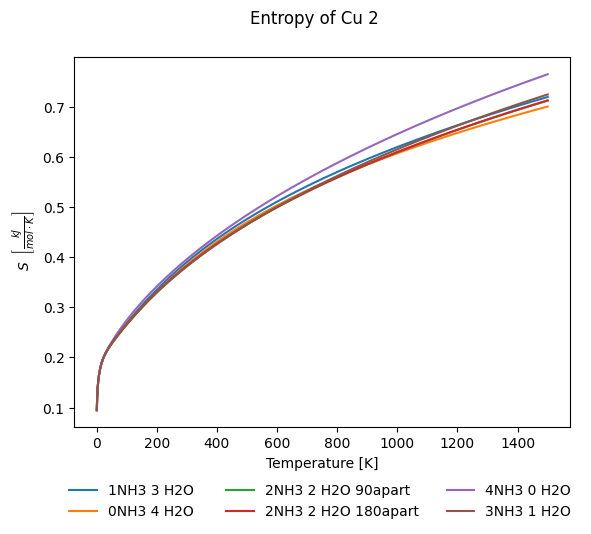

In [475]:
fig, ax = plt.subplots()

for row in new.itertuples(index=True):
    # ax.plot(interp_temp, row[-1], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]), color = colors[row[0]])
    ax.plot(interp_temp, row[-1], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]))

ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r" $ S  \; \; \left[ \frac{kJ}{mol \cdot K} \right] $")
plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2), loc='center', frameon = False)
# plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
plt.suptitle(f"Entropy of {new['Metal'][0]} {new['Charge'][0]}")

# plt.savefig("/Users/mohan/Desktop/s.png", dpi = 400, bbox_inches='tight')

plt.show();

In [476]:
# make sure data frame updates correctly since I think I'll have to hand-specify geometries 

metals = ['Cu']
charges = [2]

for metal in metals:
    for charge in charges:
        # reduced_df = filter_dataframe(df, metal = metal, charge = charge, geom = 'Square planar')
        
        ref_e = (reference_energy(new, num_ligands = 4))

        ref_s = (reference_entropy(new, num_ligands = 4))

        delta_e = (new['Total Energy (Hartree)'] + (new['H2O'] * e_nh3) - ref_e - (new['H2O'] * e_h2o) ) * har_to_kjmol

        delta_s = (new['Entropy (kJ/mol*K)'] - ref_s) 

        new.loc[new.index, 'Delta E (kJ/mol)'] = delta_e # append results back to corresponding row

        new.loc[new.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row

new

/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_79042/2966129722.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.loc[new.index, 'Delta E (kJ/mol)'] = delta_e # append results back to corresponding row
/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_79042/2966129722.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.loc[new.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
0,Cu,2,Square planar,1,3,0,,-1925.257977,293.629551,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09479282275276031, 0.0964154787372116, 0.09...",176.992041,"[-0.00021641280502211757, -0.00021641280502213..."
1,Cu,2,Square planar,0,4,0,,-1945.082482,258.343882,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09467561380063179, 0.09629826978508309, 0.0...",247.886964,"[-0.00033362175715064, -0.00033362175715064, -..."
2,Cu,2,Square planar,2,2,0,90apart,-1905.432240,327.923744,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09491732587975403, 0.09653998186420532, 0.0...",109.330133,"[-9.190967802839844e-05, -9.190967802841232e-0..."
3,Cu,2,Square planar,2,2,0,180apart,-1905.430468,327.990354,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09494929057711005, 0.09657194656156134, 0.0...",113.982939,"[-5.994498067238285e-05, -5.994498067238285e-0..."
4,Cu,2,Square planar,4,0,0,,-1865.770866,401.772002,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09500923555778243, 0.09663189154223373, 0.0...",0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,Cu,2,Square planar,3,1,0,,-1885.602719,364.494520,/Users/mohan/Desktop/Research/paolucci/data/fr...,"[0.09498716248579163, 0.09660981847024294, 0.0...",51.603668,"[-2.2073071990799664e-05, -2.2073071990785786e..."


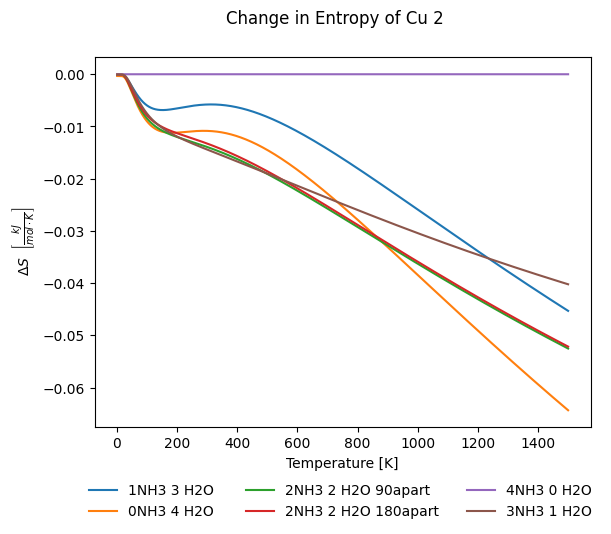

In [477]:
fig, ax = plt.subplots()

for row in new.itertuples(index=True):
    # ax.plot(interp_temp, row[-1], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]), color = colors[row[0]])
    ax.plot(interp_temp, row[-1], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]))

ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r" $ \Delta S  \; \; \left[ \frac{kJ}{mol \cdot K} \right] $")
plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2), loc='center', frameon = False)
plt.suptitle(f"Change in Entropy of {new['Metal'][0]} {new['Charge'][0]}")

# plt.savefig("/Users/mohan/Desktop/delta_s.png", dpi = 400, bbox_inches='tight')

plt.show();

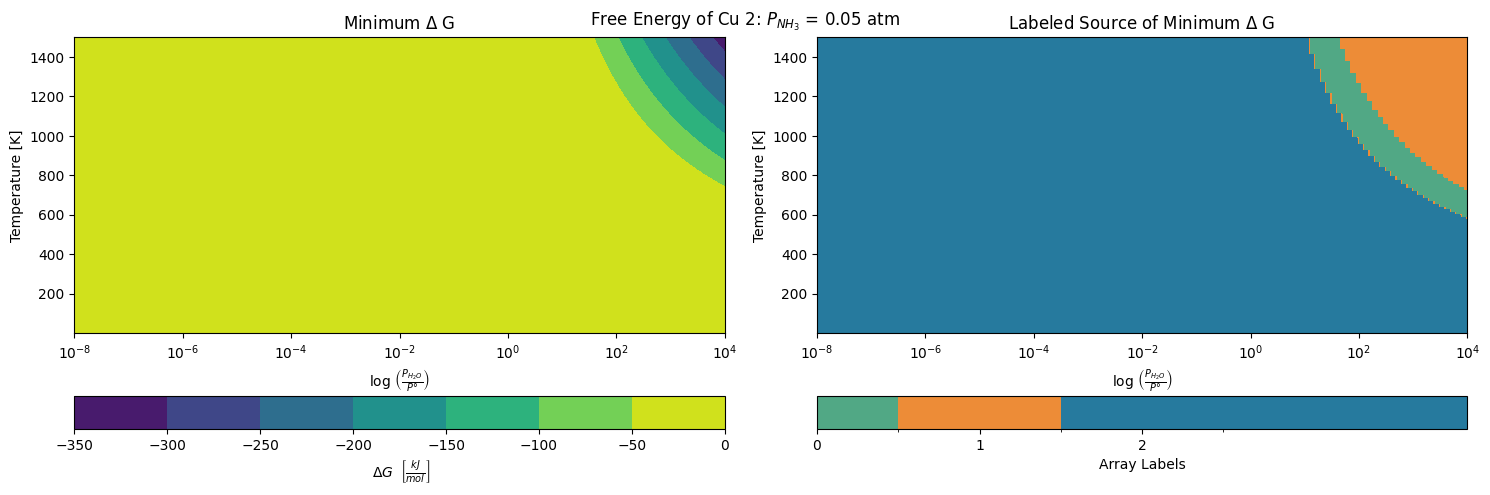

In [489]:
class fourfold():
    def __init__(self, data, temperature:np.ndarray, p_nh3:np.ndarray, p_h2o:np.ndarray):
            self.data = data 
            self.temperature = temperature
            self.p_nh3 = p_nh3
            self.p_h2o = p_h2o

    def no_mu(self):
        
        dE_TdS = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values):
            # delta[0] = dE --> delta[1] = dS
            # dE - TdS
            dE_TdS.append(delta[0] - (self.temperature * delta[1]))
        
        return dE_TdS

    def plot_no_mu(self, outfile = None):

        dE_TdS = self.no_mu()

        colors = ['#51a885', 'r', '#ed8c37', '#f5a396', '#986b9b', '#267a9e']

        linestyles = ['-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--'] # dashed lines for one type of geom

        # Iterate over rows
        
        fig, ax = plt.subplots()

        for row in self.data.itertuples(index=True):
            ax.plot(self.temperature, dE_TdS[row[0]], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]), color = colors[row[0]])
            # print(row[4], "NH3", row[5], "H2O", row[7], 'dE =', row[-1])

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta E - T \Delta S  \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')

        plt.show();


    def plot_no_mu_single(self, index, outfile = None):
        dE_TdS = self.no_mu()

        fig, ax = plt.subplots()

        interest = self.data.loc[index, :]
        
        ax.plot(self.temperature, dE_TdS[index], linestyle = '--', label = str(interest['NH3'])+r"N$H_3$ "+str(interest['H2O'])+r"H$_2$O "+str(interest['Description'])+r" $\Delta$ E = "+str(int(interest['Delta E (kJ/mol)'])))

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta E - T \Delta S  \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')

        plt.show();
        
    def vary_temp(self):

        mu_nh3 = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_h2o = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 

        # print(self.p_nh3)
        # print(self.p_h2o)

        for t, temp in enumerate(self.temperature):
            mu_nh3[t] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(self.p_nh3))
            mu_h2o[t] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(self.p_h2o))

        dE_TdS_mu = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O']):
            # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O
            # dE - TdS - y*mu(H2O) + y*mu(NH3)
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1]) - (delta[2] * mu_h2o) + (delta[2] * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o
    
    def plot_vary_temp(self, outfile = None):
            
        dE_TdS_mu, mu_nh3, mu_h2o = self.vary_temp()

        colors = ['#51a885', 'r', '#ed8c37', '#f5a396', '#986b9b', '#267a9e']

        fig, ax = plt.subplots()

        for row in self.data.itertuples(index=True):
            ax.plot(self.temperature, dE_TdS_mu[row[0]], label = str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[7]), color = colors[row[0]])
            # print(row[4], "NH3", row[5], "H2O", row[7], 'dE =', row[-1])

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}: "+r"$P_{NH_3} = "+str(self.p_nh3)+r"\; atm \;  P_{H_2 O}$ = "+str(self.p_h2o)+" atm")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')
        
        plt.show();
        
    def vary_temp_pnh3(self):
        mu_nh3 = np.zeros((len(self.temperature), len(self.p_nh3)), dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_h2o = np.zeros_like(self.temperature, dtype = np.float32) # varying temp along row; constant pres. along row

        for t, temp in enumerate(self.temperature):
            for p, pres in enumerate(self.p_nh3):
                mu_nh3[t][p] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(pres))
                mu_h2o[t] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(self.p_h2o))

        dE_TdS_mu = []

        mu_h2o = mu_h2o[:, np.newaxis]  # Shape changes from (1500, ) to (1500, 1)

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O
            # # dE - TdS - y*mu(H2O) + y*mu(NH3)
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1])[:, np.newaxis] - (delta[2] * mu_h2o) + (delta[2] * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o

        # return mu_nh3, mu_h2o

    def plot_vary_temp_pnh3(self):
        print('hi')

    def vary_temp_ph2o(self):
        mu_h2o = np.zeros((len(self.temperature), len(self.p_h2o)), dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_nh3 = np.zeros_like(self.temperature, dtype = np.float32) # varying temp along row; constant pres. along row

        for t, temp in enumerate(self.temperature):
            for p, pres in enumerate(self.p_h2o):
                mu_h2o[t][p] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(pres))
                mu_nh3[t] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(self.p_nh3))

        dE_TdS_mu = []

        mu_nh3 = mu_nh3[:, np.newaxis]  # Shape changes from (1500, ) to (1500, 1)

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O
            # # dE - TdS - y*mu(H2O) + y*mu(NH3)
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1])[:, np.newaxis] - (delta[2] * mu_h2o) + (delta[2] * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o
    
    def plot_vary_temp_ph2o(self, outfile = None):
        dE_TdS_mu, mu_nh3, mu_h2o = self.vary_temp_ph2o()

        P, T = np.meshgrid(self.p_h2o, self.temperature)

        min_values = np.minimum.reduce(dE_TdS_mu)
        
        labels = np.argmin(dE_TdS_mu, axis=0) # find minimum value at each index i, j of the tensor 

        # Create a discrete colormap for the labels
        cmap = ListedColormap(['#51a885', 'r', '#ed8c37', '#f5a396', '#986b9b', '#267a9e'])
        bounds = [-0.5, 0.5, 1.5, 2.5]
        norm = BoundaryNorm(bounds, cmap.N)

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Create contour plot for the minimum values
        contour_min = axs[0].contourf(P, T, min_values, cmap='viridis')
        cbar_min = fig.colorbar(contour_min, ax=axs[0], orientation='horizontal')
        cbar_min.set_label(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")

        # Create contour plot for the labels with the discrete colormap
        contour_labels = axs[1].contourf(P, T, labels, cmap=cmap, norm=norm)
        cbar_labels = fig.colorbar(contour_labels, ax=axs[1], orientation='horizontal', ticks=[0, 1, 2])
        cbar_labels.set_label('Array Labels')

        # Add labels and title to each subplot
        axs[0].set_xlabel(r'log $\left(  \frac{P_{H_2O}}{P \degree} \right)$')
        axs[0].set_xscale('log')
        axs[0].set_ylabel('Temperature [K]')
        axs[0].set_title(r'Minimum $\Delta$ G')

        axs[1].set_xlabel(r'log $\left(  \frac{P_{H_2O}}{P \degree} \right)$')
        axs[1].set_xscale('log')
        axs[1].set_ylabel('Temperature [K]')
        axs[1].set_title(r'Labeled Source of Minimum $\Delta$ G')

        # Adjust layout
        plt.tight_layout()

        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}: "+r"$P_{NH_3}$ = "+str(self.p_nh3)+" atm")


        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')

        # Show plot
        plt.show();

    def vary_pnh3_ph2o(self):
        print('hi')

#-------------------------------------------------------------------------------- */
# VARY TEMP

# cu2_sp = fourfold(data = new, temperature = interp_temp, p_nh3 = 0.05, p_h2o = 40)

# cu2_sp.plot_no_mu(outfile = '/Users/mohan/Desktop/no_mu.png')

# cu2_sp.plot_no_mu_single(index = 1)

# cu2_sp.plot_vary_temp(outfile = '/Users/mohan/Desktop/free_energy.png')

#-------------------------------------------------------------------------------- */
# VARY TEMP, P_NH3

# step = 0.1

# p = np.arange(-8, 2+step, step)

# pressure_nh3 = np.power(10, p) # units atm

# cu2_sp = fourfold(data = new, temperature = interp_temp, p_nh3 = pressure_nh3, p_h2o = 40)

# cu2_sp.plot_no_mu(outfile = '/Users/mohan/Desktop/no_mu.png')

# cu2_sp.plot_no_mu_single(index = 1)

# cu2_sp.plot_vary_temp(outfile = '/Users/mohan/Desktop/free_energy.png')

# dE_TdS_mu , mu_nh3, mu_h2o = cu2_sp.vary_temp_pnh3()
#-------------------------------------------------------------------------------- */
# VARY TEMP, P_H2O

step = 0.1

p = np.arange(-8, 4+step, step)

pressure_h2o = np.power(10, p) # units atm

cu2_sp = fourfold(data = new, temperature = interp_temp, p_nh3 = 0.05, p_h2o = pressure_h2o)

dE_TdS_mu, mu_nh3, mu_h2o = cu2_sp.vary_temp_ph2o()

# cu2_sp.plot_vary_temp_ph2o(outfile = '/Users/mohan/Desktop/contour.png')